# Libraries

In [114]:
import rasterio

import pandas as pd

import numpy as np

import os

from pathlib import Path
from pandas import DataFrame

import matplotlib.pyplot as plt

from osgeo import gdal, gdalconst
from os import path

from osgeo import gdal, gdalconst

import geopandas as gpd

from shapely.geometry import Polygon


# Global 

In [62]:
os.chdir('/home/pierre-louis/forest_mind/analysis')

In [63]:
IMAGES_DATA_PATH = "/mnt/uksa-storage/guatemala/"
ref_year = 2017
years = list(range(2018,2021))


# Helpers

# Deforestation CSVs
## Import deforestation data

In [64]:
## Import deforestation CSVs
# list of time variant raster names
pathlist = list(Path("intermediate").glob('*_ds.tif'))
df_file_paths = list(map(lambda y: f"intermediate/deforestation_{y}_ds.csv", years)) 
dist_df_file_paths = list(map(lambda y: f"intermediate/distance_to_deforestation_in_year_{y}_ds.csv", years)) 
print(df_file_paths)
#print(dist_df_file_paths)


['intermediate/deforestation_2018_ds.csv', 'intermediate/deforestation_2019_ds.csv', 'intermediate/deforestation_2020_ds.csv']


In [65]:
defor_2018 = pd.read_csv(df_file_paths[0])
(defor_2018!=0).count()

0    3785719
dtype: int64

In [66]:
a,b = np.unique(defor_2018, return_counts = True)
print(a)
print(b)

[0 1]
[3755522   30197]


# Raster

## Land use

In [68]:
lu_file_path = '/mnt/uksa-storage/land_cover/2017/Smoothed/GSI_LandNow_LCC_2017_Iteration_2_Smoothed'

In [69]:
lu = rasterio.open(lu_file_path+'.tif')
a, b = np.unique(lu.read(1), return_counts = True)
print(a)
print(b)

[-9999     1     2     3     4     5     7    10    11]
[4427012  267958  153020 1569697  220044  273611   11511 5813304 3135186]


In [70]:
# Open land use raster, create identical forest_mask raster with 1 for forest and 0 for other land uses. 
with rasterio.open(lu_file_path+'.tif') as src:
    profile = src.profile
    with rasterio.open('forest_mask.tif', 'w', **profile) as dst:
        data = src.read(1)
        data = np.where(data==10, 1, 0)
        data.dtype='int16'
        dst.write(data, indexes =1)

In [71]:
forest_mask = rasterio.open('forest_mask.tif')

In [72]:
c, d = np.unique(forest_mask.read(1), return_counts = True)
print(c)
print(d)
# Check that forest land use has the same size
b[7]==d[1]

[0 1]
[10058039  5813304]


True

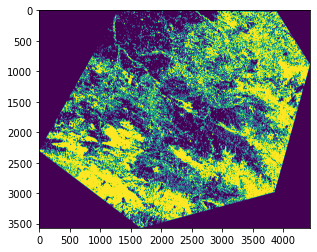

In [73]:
plt.imshow(forest_mask.read(1))

In [74]:
forest_mask.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 4447, 'height': 3569, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(10.0, 0.0, 603310.0,
       0.0, -10.0, 1742400.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

In [75]:
forest_mask.bounds

BoundingBox(left=603310.0, bottom=1706710.0, right=647780.0, top=1742400.0)

## Forest change 

In [76]:
rasterio.open(IMAGES_DATA_PATH+'disturbances/forest_change_by_year.tif').profile

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': 0.0, 'width': 4401, 'height': 3440, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(10.0, 0.0, 603558.1124792217,
       0.0, -10.0, 1742194.128229793), 'tiled': False, 'interleave': 'band'}

In [134]:
a, b = np.unique(rasterio.open(IMAGES_DATA_PATH+'disturbances/forest_change_by_year.tif').read(1), return_counts = True)
print(a)
print(b)

[   0 2018 2019 2020]
[15021061    64077    46052     8250]


In [77]:
with rasterio.open(IMAGES_DATA_PATH+'disturbances/forest_change_by_year.tif') as src:
    profile = src.profile
    bounds = src.bounds
    defor = src.read(1)
    a, b = np.unique(defor, return_counts = True)
    with rasterio.open('/home/pierre-louis/forest_mind/analysis/intermediate/deforestation_mask.tif', 'w', **profile) as dst:
        data = src.read(1)
        data = np.where(data!=0, 1, 0)
        c, d = np.unique(data, return_counts = True)
        data.dtype='int32'
        dst.write(data, indexes =1)


In [78]:
# Check that sum deforestation in 2018, 2019, 2020 == deforestation mask = 1. 
print(int(sum(b[1:])))
sum(b[1:])==d[1]

118379


True

In [80]:
defor_mask = rasterio.open('/home/pierre-louis/forest_mind/analysis/intermediate/deforestation_mask.tif')

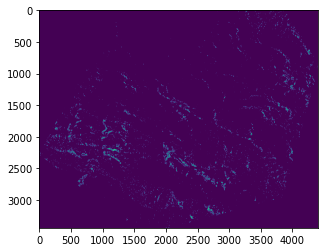

In [81]:
plt.imshow(defor_mask.read(1))

In [82]:
defor_mask.transform == forest_mask.transform

False

In [83]:
defor_mask.bounds

BoundingBox(left=603558.1124792217, bottom=1707794.128229793, right=647568.1124792217, top=1742194.128229793)

In [84]:
forest_mask.bounds

BoundingBox(left=603310.0, bottom=1706710.0, right=647780.0, top=1742400.0)

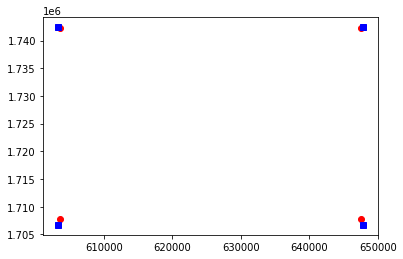

In [85]:
plt.plot([defor_mask.bounds.left, defor_mask.bounds.left, defor_mask.bounds.right, defor_mask.bounds.right], [defor_mask.bounds.top, defor_mask.bounds.bottom, defor_mask.bounds.top, defor_mask.bounds.bottom], 'ro')
plt.plot([forest_mask.bounds.left, forest_mask.bounds.left, forest_mask.bounds.right, forest_mask.bounds.right], [forest_mask.bounds.top, forest_mask.bounds.bottom, forest_mask.bounds.top, forest_mask.bounds.bottom], 'bs')
plt.show()

In [86]:
x_min = max(defor_mask.bounds.left, forest_mask.bounds.left)
print('x_min: '+str(x_min))
x_max = min(defor_mask.bounds.right, forest_mask.bounds.right)
print('x_max: '+str(x_max))
y_min = max(defor_mask.bounds.bottom, forest_mask.bounds.bottom)
print('y_min: '+str(y_min))
y_max = min(defor_mask.bounds.top, forest_mask.bounds.top)
print('y_max: '+str(y_max))

x_min: 603558.1124792217
x_max: 647568.1124792217
y_min: 1707794.128229793
y_max: 1742194.128229793


In [95]:
#gdalwarp -te <x_min> <y_min> <x_max> <y_max> input.tif clipped_output.tif
## Weirdly this did not work, so had to use other approach with -crop_to_cutline and a shapefile
! gdalwarp -te x_min y_min x_max y_max -overwrite "/mnt/uksa-storage/land_cover/forest_mask.tif" "/home/pierre-louis/forest_mind/analysis/intermediate/clipped_forest_mask.tif"

Creating output file that is 4447P x 3569L.
Processing input file /mnt/uksa-storage/land_cover/forest_mask.tif.
Using internal nodata values (e.g. -9999) for image /mnt/uksa-storage/land_cover/forest_mask.tif.
Copying nodata values from source /mnt/uksa-storage/land_cover/forest_mask.tif to destination /home/pierre-louis/forest_mind/analysis/intermediate/clipped_forest_mask.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [88]:
## Weirdly this did not work, so had to use other approach with -crop_to_cutline and a shapefile
ds = gdal.Open('/mnt/uksa-storage/land_cover/forest_mask.tif')
ds = gdal.Translate('/home/pierre-louis/forest_mind/analysis/intermediate/clipped_forest_mask.tif', ds, projWin = [x_min, y_min, x_max, y_max])
ds = None
test = rasterio.open('/home/pierre-louis/forest_mind/analysis/intermediate/clipped_forest_mask.tif')
test.profile

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 4447, 'height': 3569, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(10.0, 0.0, 603310.0,
       0.0, -10.0, 1742400.0), 'tiled': False, 'interleave': 'band'}

In [135]:
#create cutline shapefile that will be used to crop forest_mask raster to the right size
bbox = Polygon([[x_min, y_min],[x_min, y_max],[x_max,y_max],[x_max,y_min]])

gpd.GeoDataFrame(pd.DataFrame(['p1'], columns = ['geom']),
     crs = {'init':'epsg:32615'},
     geometry = [bbox]).to_file('cutline.shp')

/home/ubuntu/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

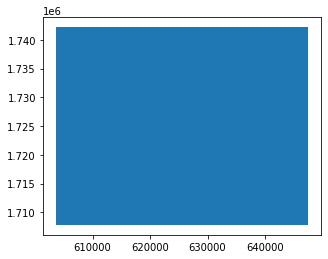

In [136]:
# plot cutline shapefile
gpd.read_file('cutline.shp').plot()

In [140]:
! gdalwarp -crop_to_cutline -cutline cutline.shp -overwrite /mnt/uksa-storage/land_cover/forest_mask.tif /home/pierre-louis/forest_mind/analysis/intermediate/clipped_forest_mask.tif


Creating output file that is 4401P x 3440L.
Processing input file /mnt/uksa-storage/land_cover/forest_mask.tif.
Using internal nodata values (e.g. -9999) for image /mnt/uksa-storage/land_cover/forest_mask.tif.
Copying nodata values from source /mnt/uksa-storage/land_cover/forest_mask.tif to destination /home/pierre-louis/forest_mind/analysis/intermediate/clipped_forest_mask.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [141]:
rasterio.open("/home/pierre-louis/forest_mind/analysis/intermediate/clipped_forest_mask.tif").bounds

BoundingBox(left=603558.1124792217, bottom=1707794.128229793, right=647568.1124792217, top=1742194.128229793)

In [142]:
cl_forest_mask = rasterio.open("/home/pierre-louis/forest_mind/analysis/intermediate/clipped_forest_mask.tif")
cl_forest_mask.bounds

BoundingBox(left=603558.1124792217, bottom=1707794.128229793, right=647568.1124792217, top=1742194.128229793)

In [143]:
# Check that the bounds have changed. Should get False
forest_mask.bounds==cl_forest_mask.bounds

False

In [146]:
# Check that the bounding box of clipped_forest_mask raster and defor_mask raster are the same. Should get True
cl_forest_mask.bounds==defor_mask.bounds

True

In [144]:
# Check that the shape of clipped_forest_mask raster and defor_mask raster are the same. Should get True
cl_forest_mask.shape==defor_mask.shape

True

In [127]:
# element-wise multiplication. 1 forest*1 deforestation = 1 forest deforested, else 0 forest deforested. 
check_defor = np.multiply(cl_forest_mask.read(1), defor_mask.read(1))
check_defor

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [128]:
a, b = np.unique(check_defor, return_counts = True)
print(a)
print(b)
print("Total forest cover effectively deforested: "+str(b[1]))

[0 1]
[15053343    86097]
Total forest cover effectively deforested: 86097


In [129]:
c, d = np.unique(defor_mask.read(1), return_counts = True)
print(c)
print(d)
print("Total deforested area: "+str(d[1]))

[0 1]
[15021061   118379]
Total deforested area: 118379


In [133]:
# check that number of pixels is the same in both raster
sum(b[:])==sum(d[:])

True

In [130]:
# Check that total forest cover effectively deforested = Total deforested area
b[1]==d[1]

False

In [145]:
# Difference between total forest cover effectively deforested and total deforested area
b[1]-d[1]

-54302

In [ ]:
#gdal_calc.py --calc=expression --outfile=out_filename [-A filename]
            # [--A_band=n] [-B...-Z filename] [other_options]
!gdal_calc.py --calc="multiply(A,B)" --outfile "" -A "/home/pierre-louis/forest_mind/analysis/intermediate/clipped_forest_mask.tif" -B "/home/pierre-louis/forest_mind/analysis/intermediate/deforestation_mask.tif"